# Восстановление золота из руды

Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Используйте данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Вам нужно:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

Чтобы выполнить проект, обращайтесь к библиотекам *pandas*, *matplotlib* и *sklearn.* Вам поможет их документация.

## 1. Подготовка данных

In [83]:
# необходимые библиотеки
import pandas as pd
from sklearn.metrics import mean_absolute_error
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import re
from sklearn.model_selection import KFold, cross_validate, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [84]:
try:
    df_full = pd.read_csv('datasets/gold_recovery_full_new.csv')
    df_test = pd.read_csv('datasets/gold_recovery_test_new.csv')
    df_train = pd.read_csv('datasets/gold_recovery_train_new.csv')
except:
    df_full = pd.read_csv('datasets/gold_recovery_full_new.csv')
    df_test = pd.read_csv('datasets/gold_recovery_test_new.csv')
    df_train = pd.read_csv('datasets/gold_recovery_train_new.csv')
    
data = [df_full, df_test, df_train]


In [85]:
names = ['Полные данные', 'Тестовая выборка','Тренировочная выборка']

### 1.1. Описание данных

In [86]:
#Проведем краткое описание датасета
def describe(d, n):
    print('* Имя датасета', n)
    print('* Размерность', d.shape)
    print('* Количество NA', d.isna().sum().sum())
    print('* Всего дубликатов', d.duplicated().sum())
    print('* Информация по столбцам')
    print(d.info())
    print('* Столбцы с Nan - ', len(d.columns[d.isna().any()]), 'шт' )
    print(d.columns[d.isna().any()])

In [87]:
for i in range(len(data)):
    describe(data[i], names[i])
    print('-----------------------------------------------------------------------------------------------------')

In [88]:
#Посмотрим, каких столбцов не хватает в тестовой выборке по сравнению с тренировочной
list_columns = [i for i in df_train.columns if i not in df_test.columns]
w0 = []
w1 = []
w2 = []
for i in list_columns:
    w = list(map(str,i.split(".")))
    if w[0] not in w0:
        w0.append(w[0]) 
    if w[1] not in w1:
        w1.append(w[1]) 
    if w[2] not in w2:
        w2.append(w[2]) 
print('Не заполнено этапов - ', len(w0), ', а именно', w0)
print('Не заполнено типов параметра - ', len(w1), ', а именно', w1)
print('Не заполнено названий параметра - ', len(w2), ', а именно', w2)
print('----------------------------------------')
print(list_columns)

Выводы:
 1. Имеется большое количество пропусков, по разным столбцам.
 2. Разное количестdо столбцов по выборке Train и Test (отличется на 30+ штук). Отсутствуют как расчетные, так и выходные данные по всем этапам. Я бы отметил отсутствие 2 наиболее значимых столбцов - final.output.recovery и rougher.output.recovery, которые по условиям задачи являются целевыми.
 3. Столбец data во всех датасетах надо привести к типу data

### 1.2. Проверка правильности расчета эффективности обогащения золота

In [89]:
rec = data[2]['rougher.output.recovery']

F = data[2]['rougher.input.feed_au'] #F — доля золота в сырье/концентрате до флотации/очистки;
C = data[2]['rougher.output.concentrate_au'] #C — доля золота в концентрате после флотации/очистки;
T = data[2]['rougher.output.tail_au'] #T — доля золота в отвальных хвостах после флотации/очистки.

rec_hat = (C*(F-T))/(F*(C-T))*100
print('MAE', mean_absolute_error(rec.dropna(), rec_hat.dropna()))

Вывод: расчет эффективности обогащения произведен верно

### 1.3. Заполнение Nan и изменение типа даты

In [90]:
for i in range(len(data)):
    data[i] = data[i].fillna(method='ffill')
    data[i]["date"] = pd.to_datetime(data[i]["date"]) 

In [91]:
for d in data:
    print('Количество NA', d.isna().sum().sum())

## 2. Анализ данных

### 2.1 Концентрация металлов на различных этапах очистки

In [92]:
met = ['_au', '_pb', '_ag']
level = ['rougher.input.feed', 'rougher.output.concentrate', 'primary_cleaner.output.concentrate', 'final.output.concentrate']
d = pd.DataFrame()
for i in range(len(met)):
    for j in level:
        d.loc[i, 'id'] = met[i]
        d.loc[i, j] = round(data[0][j+met[i]].mean(), 2)    

Вывод: концентрация золота и свинца растет с ростом очистки, а по серебру - сначала растет, а потом начинает падать

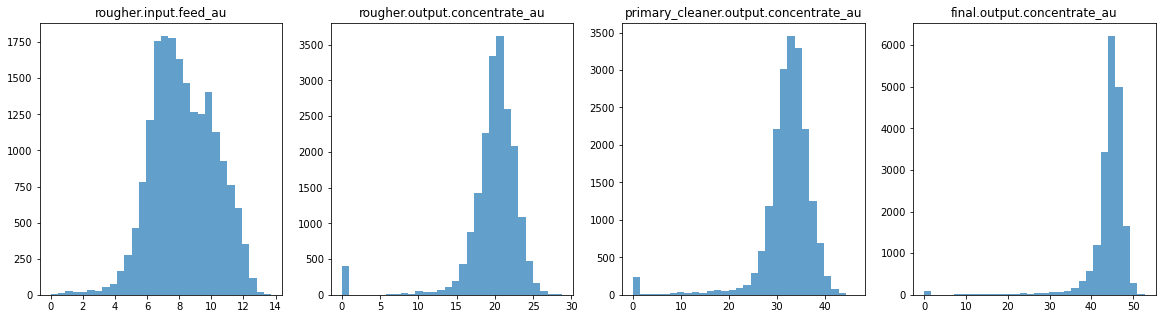

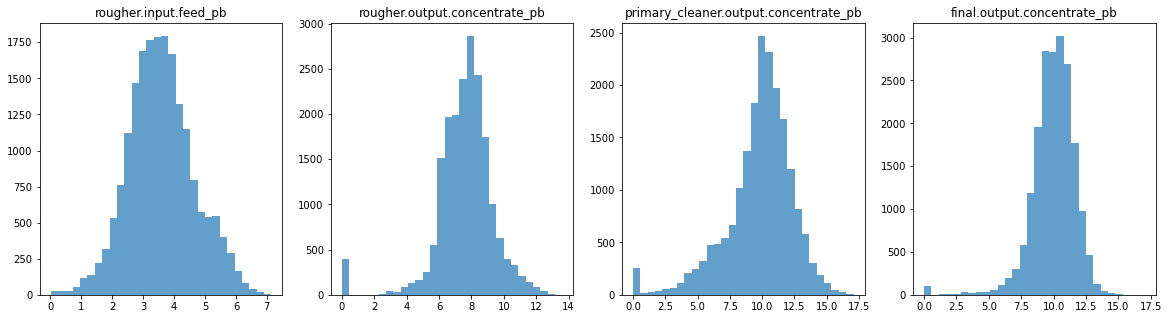

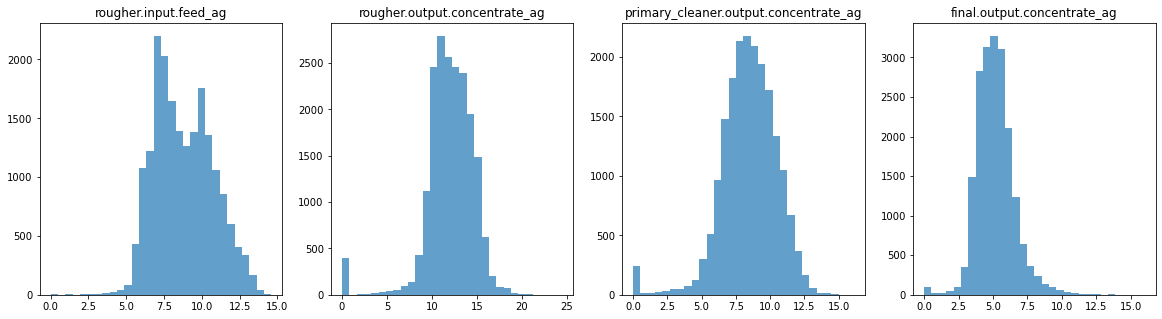

In [94]:
for j in range(len(met)):
    fig, ax = plt.subplots(1,4,figsize=(20,5))
    for i in range(len(level)):
        ax[i].hist(x=data[0][level[i]+met[j]], bins = 30, alpha=0.7)
        ax[i].set_title(level[i]+met[j])
    plt.show()

### 2.2 Размер гранул сырья на обучающей и тестовой выборке

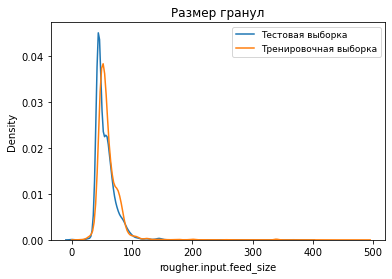

In [95]:
for i in range(1, len(data)):
    sns.distplot(data[i]['rougher.input.feed_size'], hist = False, kde = True, label = names[i])

plt.legend(prop={'size': 9})
plt.title('Размер гранул')   

Вывод: Распределение размера гранул на обеих выборках почти идентичны. Следует заметить, что график смещен влево, что говорит о наличии выбросов

### 2.3 Суммарная концентрация всех веществ на разных стадиях

In [96]:
#Создадим списки, чтобы дальше использовать их для простоты кода
level = ['rougher.input.feed', 'rougher.output.concentrate','primary_cleaner.output.concentrate', 'final.output.concentrate']
lev_names = ['сырье', 'конц. после флотации', 'конц. после первичной очистки', 'финальный конц.']
met = ['_au', '_pb', '_ag']

#создадим таблицу
d1 = pd.DataFrame()
for i in range(len(level)):
    d1[lev_names[i]] = data[0][[level[i]+met[0],level[i]+met[1],level[i]+met[2]]].sum(axis=1)

d1.head(10)

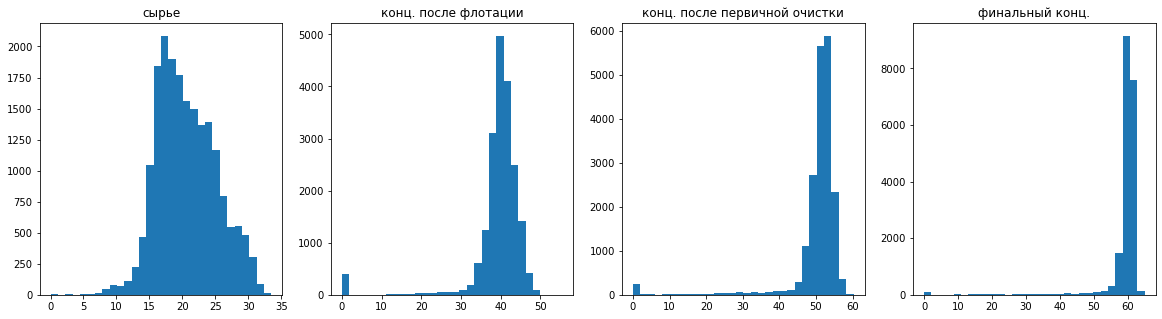

In [97]:
fig, ax = plt.subplots(1,4,figsize=(20,5))
for i in range(len(level)):
    ax[i].hist(x=d1[lev_names[i]], bins = 30)
    ax[i].set_title(lev_names[i])
plt.show()

Вывод: данные сильно скошены. Много нулевых значений. Для дальнейшей обработки необходимо сформировать "ящик с усами". Видно также, что присутствует достаточно много нулевых значений. 

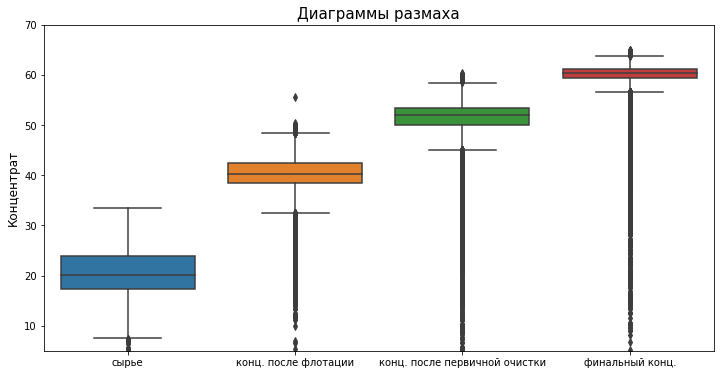

In [98]:
plt.figure(figsize=(12,6))
sns.boxplot(data=d1)
plt.title('Диаграммы размаха', fontsize=15)
plt.ylabel('Концентрат',fontsize=12)
plt.ylim([5, 70])

In [99]:
#Мне видится, что если концентрация на каком-либо этапе по металлу равна нулю, то эту строку всю можно считать ошибкой. 
#Ненулевые значения удалять не будем, т.к. мы тогда потеряем часть признаков. Делаем это на тренировочной и на тестовой выборке. 

for m in met:
    met_columns = [i+m for i in level] 
    data[2] = data[2][data[2][met_columns].min(axis=1) > 0]
    cc = [j for j in met_columns if j in data[1].columns.to_list()] # выберем только те столбцы из  met_columns, которые есть в test
    data[1] = data[1][data[1][cc].min(axis=1) > 0]
    

In [100]:
#Примечание. Практика показала, концентрация по разным металлам отсутствует в одних и тех же строках. 
#См. пример строки 22
for m in met:
    print(df_train[[i+m for i in level]].iloc[22],'\n')

## 3. Модель

### 3.1. Функции ошибок

In [101]:
def sMAPE(y_true,y_pred):
    smape = abs(y_true - y_pred)/((abs(y_true)+abs(y_pred))/2)*100   
    smape = smape.fillna(value=0)    
    return sum(smape)/len(smape)

In [102]:
def final_sMAPE(sMAPE_rougher,sMAPE_final):
    return (0.25*sMAPE_rougher + 0.75*sMAPE_final)

### 3.2. Прогноз показателей

In [103]:
#Добавим target столбцы в тестовый датасет, т.к. в train они и так есть
data[1]= data[1].merge(data[0][['date', 'rougher.output.recovery', 'final.output.recovery']], 
                       how = 'left', on = 'date')

In [104]:
#Сделаем датаесты train, test одинаковыми по количеству столбцов
data[2] = data[2][data[1].columns]

In [105]:
# Создадим  features и target
target_train_rougher, target_train_final = data[2]['rougher.output.recovery'], data[2]['final.output.recovery']
#Для прогнозирования грубой очистки нужны только сведения по грубой очистке
rougher = [x for x in data[1].columns.to_list() if re.search('rougher', x)]
features_train_rougher = data[2][rougher].drop(['rougher.output.recovery'], axis=1) 
features_train_final = data[2].drop(['rougher.output.recovery', 'final.output.recovery', 'date'], axis=1) 


target_test_rougher, target_test_final = data[1]['rougher.output.recovery'], data[1]['final.output.recovery']
features_test_rougher = data[1][rougher].drop(['rougher.output.recovery'], axis=1) 
features_test_final = data[1].drop(['rougher.output.recovery', 'final.output.recovery', 'date'], axis=1) 

In [106]:
#Сформируем функцию подбора параметров
def grid_search(param, X,y):
    
    cv = KFold(5, shuffle=True, random_state=42)
    scorer = make_scorer(sMAPE, greater_is_better=False)
    GridModel = GridSearchCV(estimator=param['model'], param_grid=param['params'], cv=cv, scoring=scorer, verbose=0)
    GridModel.fit(X, y)
    
    return GridModel.best_score_, GridModel.best_params_, GridModel.best_estimator_

In [112]:
#Сформируем параметры моделей

#DecisionTreeRegressor()
p1 = {'model':DecisionTreeRegressor(),
      'name': 'DecisionTreeRegressor',
      'params': {'max_depth': [2, 3, 15, 20],
                 'min_samples_split': [2, 4, 6]}}

#RandomForestRegressor()
p2 = {'model':RandomForestRegressor(),
      'name': 'RandomForestRegressor',
      'params': {'n_estimators': [10, 20, 50],  
                 'max_features': ['sqrt']}}

#LinearRegression()
p3 = {'model':LinearRegression(),
      'name': 'LinearRegression',
      'params': {'fit_intercept': [True]}}

#Ridge()
p4 = {'model': Ridge(),
      'name': 'Ridge', 
      'params': {'alpha': [0.1, 1.5, 10, 20, 300, 500]}}

#Dummy() чтобы сравнить все модели о случайным прогнозированием
p5 = {'model': DummyRegressor(),
      'name': 'Dummy', 
      'params': {'strategy': ['mean', 'median']}}


param = [p1, p2, p3, p4, p5]
#param = [p3, p4, p5]

In [113]:
d2 = pd.DataFrame()
best_sMape_r = -1000
best_sMape_f = -1000
for i in range(len(param)):
    print(param[i]['name'])
    a,b, model_r = grid_search(param[i], features_train_rougher, target_train_rougher)
    d2.loc[i, 'sMape_r'] = a
    d2.loc[i, 'model_r'] = param[i]['name'] + str(b)
    
    c,d, model_f = grid_search(param[i], features_train_final, target_train_final)
    d2.loc[i, 'sMape_f'] = c
    d2.loc[i, 'model_f'] = param[i]['name'] + str(d)
    d2.loc[i, 'sMape_final'] = final_sMAPE(a, c)
    
    #Функция final_sMAPE - линейная. Мое мнение, что минимального значения она достигает
    # при минимальных значения аргументов в нее входящих. Поэтому будем искать минимальные sMape
    # по-отдельности
    
    if a > best_sMape_r:
        print()
        best_model_r = model_r
        best_sMape_r = a
        min_r = 'best - '+ param[i]['name'] + str(b)
        
    if c > best_sMape_f:
        best_model_f = model_f
        best_sMape_f = c
        min_f = 'best - '+ param[i]['name'] + str(d)

#Занесем в таблицу последней строкой
d2.loc[i+1, 'sMape_r'] = best_sMape_r
d2.loc[i+1, 'model_r'] = min_r
d2.loc[i+1, 'sMape_f'] = best_sMape_f
d2.loc[i+1, 'model_f'] = min_f
d2.loc[i+1, 'sMape_final'] = final_sMAPE(best_sMape_r, best_sMape_f) 

Выводы:
1. Лучшее предсказание по rougher и final совпало - RandomForestRegressor{'max_features': 'sqrt', 'n_estimators': 10}.
2. Результат получился лучше, чем  Dummy. 

### 3.3. Прогноз на тестовой выборке

In [115]:
y_r = best_model_r.predict(features_test_rougher)
y_f = best_model_f.predict(features_test_final)
sMape_r = sMAPE(target_test_rougher, y_r)
sMape_f = sMAPE(target_test_final, y_f)
print('Итоговый sMape = ', final_sMAPE(sMape_r, sMape_f))

In [116]:
#Сравним с Dummy, он считался последим, модели остались в памяти
y_r = model_r.predict(features_test_rougher)
y_f = model_f.predict(features_test_final)
sMape_r = sMAPE(target_test_rougher, y_r)
sMape_f = sMAPE(target_test_final, y_f)
print('Итоговый sMape = ', final_sMAPE(sMape_r, sMape_f))

Общие выводы:
1. Произвели исследовательский анализ данных, проверили наличие пропусков, дубликатов. 
2. Обнаружили, что концентрация золота и свинца увеличивается с каждым этапом, а концентрация серебра снижается после флотации.
3. Распределения размеров гранул в train и test выборках одинаковы.
4. Суммарные распределения концентрации скошены влево, а также имеют множество нулевых значений. Избавились от выбросов.
5. Наилучшая модель - RandomForestRegressor, со значением метрики smape 9.3, что лучше, чем у константной модели.

## Чек-лист готовности проекта

- [x]  Jupyter Notebook открыт
- [X]  Весь код выполняется без ошибок
- [X]  Ячейки с кодом расположены в порядке выполнения
- [X]  Выполнен шаг 1: данные подготовлены
    - [X]  Проверена формула вычисления эффективности обогащения
    - [X]  Проанализированы признаки, недоступные в тестовой выборке
    - [X]  Проведена предобработка данных
- [X]  Выполнен шаг 2: данные проанализированы
    - [X]  Исследовано изменение концентрации элементов на каждом этапе
    - [X]  Проанализированы распределения размеров гранул на обучающей и тестовой выборках
    - [X]  Исследованы суммарные концентрации
- [X]  Выполнен шаг 3: построена модель прогнозирования
    - [X]  Написана функция для вычисления итогового *sMAPE*
    - [X]  Обучено и проверено несколько моделей
    - [X]  Выбрана лучшая модель, её качество проверено на тестовой выборке